In [1]:
import pandas as pd
import numpy as np
from patsy import dmatrices
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from scipy.stats import chi2

from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

C:\Users\nammy\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\nammy\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


https://timeseriesreasoning.com/contents/negative-binomial-regression-model/

In [14]:
regression_data = pd.read_csv("../output_data/seth/sub_level_data.csv")
regression_data['age_in_years'] = regression_data.age_in_months/12
regression_data['log_subscribers'] = np.log(regression_data.subscribers_1 + 2)
regression_data

,communityID,added,changed,deleted,unchanged,subscribers_1,subscribers_2,rules_1,rules_2,timestamp_1,timestamp_2,founding_date,age_in_months,age_in_years,log_subscribers,age_and_subs,rules_and_subs,rules_and_age
0,007_link,0.0,0.0,0.0,1.0,7,7,1,1,1.627687e+09,1.644941e+09,1.579930e+09,14.908671,1.242389,2.197225,2.729808,2.197225,1.242389
1,007nightfire,0.0,0.0,0.0,5.0,68,91,5,5,1.625925e+09,1.643361e+09,1.609863e+09,3.526107,0.293842,4.248495,1.248388,21.242476,1.469211
2,00games,0.0,0.0,0.0,4.0,2,3,4,4,1.630524e+09,1.646246e+09,1.580752e+09,14.596170,1.216347,1.386294,1.686216,5.545177,4.865390
3,00saesthetics,0.0,0.0,0.0,6.0,2836,2995,6,6,1.624697e+09,1.642362e+09,1.562924e+09,21.375357,1.781280,7.950855,14.162697,47.705129,10.687678
4,00sbabies,0.0,0.0,0.0,6.0,300,298,6,6,1.625180e+09,1.642880e+09,1.595696e+09,8.913409,0.742784,5.710427,4.241614,34.262562,4.456704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130846,zyramains,0.0,0.0,0.0,9.0,10085,11382,9,9,1.624172e+09,1.642224e+09,1.419736e+09,75.824785,6.318732,9.219003,58.252408,82.971025,56.868588
130847,zyxcomments,0.0,0.0,0.0,1.0,8,8,1,1,1.627579e+09,1.644794e+09,1.562897e+09,21.385681,1.782140,2.302585,4.103529,2.302585,1.782140
130848,zyzz,1.0,0.0,1.0,1.0,7245,11991,2,2,1.624310e+09,1.642229e+09,1.311994e+09,116.795459,9.732955,8.888343,86.509841,17.776686,19.465910
130849,zztails,0.0,0.0,0.0,2.0,137,142,2,2,1.625469e+09,1.643165e+09,1.546838e+09,27.492575,2.291048,4.934474,11.305116,9.868948,4.582096


In [15]:
regression_data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Poisson Regression

In [33]:
mask = np.random.rand(len(regression_data)) < 0.7
df_train = regression_data[mask]
df_test = regression_data[~mask]

change_type = 'added'
expr = f"""{change_type} ~ rules_1  + age_in_years + log_subscribers + 
        age_in_years*log_subscribers + rules_1*log_subscribers + rules_1*age_in_years"""
# expr = f"""{change_type} ~ rules_1 + log_subscribers + rules_and_subs + age_and_subs + subscribers_1 + rules_and_subs""" # best model compared to above so far


y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

In [34]:
poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit(cov_type='HC3')
print(poisson_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  added   No. Observations:                91230
Model:                            GLM   Df Residuals:                    91223
Model Family:                 Poisson   Df Model:                            6
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -36103.
Date:                Thu, 18 May 2023   Deviance:                       60480.
Time:                        21:04:13   Pearson chi2:                 3.42e+05
No. Iterations:                     7                                         
Covariance Type:                  HC3                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

# Get alpha

In [35]:
df_train['type_lambda'] = poisson_training_results.mu

<ipython-input-35-c1ca5e251f17>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['type_lambda'] = poisson_training_results.mu


In [36]:
df_train['AUX_OLS_DEP'] = df_train.apply(lambda x: ((x[f'{change_type}'] - x['type_lambda'])**2 - x['type_lambda']) / x['type_lambda'], axis=1)

<ipython-input-36-7d7aa2d0f563>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['AUX_OLS_DEP'] = df_train.apply(lambda x: ((x[f'{change_type}'] - x['type_lambda'])**2 - x['type_lambda']) / x['type_lambda'], axis=1)


In [37]:
ols_expr = """AUX_OLS_DEP ~ type_lambda - 1"""
aux_olsr_results = smf.ols(ols_expr, df_train).fit()

In [38]:
print(aux_olsr_results.params)

type_lambda    7.853994
dtype: float64


In [39]:
aux_olsr_results.tvalues # this is significant

type_lambda    7.660294
dtype: float64

# Train Negative Binomial Regression Model

change age in months to age in years
remove subscribers
look into elegantly constructing interaction terms in python
look into a robust model (covariance type)
change P threshhold to 0.01

In [40]:
nb2_training_results = sm.GLM(y_train, X_train,family=sm.families.NegativeBinomial(alpha=aux_olsr_results.params[0])).fit(cov_type='HC3')
print(nb2_training_results.summary(alpha=0.01))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  added   No. Observations:                91230
Model:                            GLM   Df Residuals:                    91223
Model Family:        NegativeBinomial   Df Model:                            6
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -23760.
Date:                Thu, 18 May 2023   Deviance:                       19630.
Time:                        21:04:15   Pearson chi2:                 2.22e+05
No. Iterations:                    13                                         
Covariance Type:                  HC3                                         
                                   coef    std err          z      P>|z|      [0.005      0.995]
------------------------------------------------------------------------------------------------
Intercept       

In [41]:
#     1 scatterplot x = #subscribers, y = sum(rules changed  + rules deleted)
x = np.array(sub_metadata.subscribers_1 + 2)
y = np.array(sub_metadata.deleted + sub_metadata.changed) + np.random.normal(0,0.3,len(sub_metadata))
# Plot the scatter plot with the calculated area
plt.scatter(x, y, alpha=0.3)
plt.xscale("log")

# LOESS smoother
sample_size = 10000
sample_indices = np.random.choice(len(x), sample_size, replace=False)
x_sample = x[sample_indices]
y_sample = y[sample_indices]
smoothed = lowess(y_sample, x_sample, frac=0.3)
plt.plot(smoothed[:,0], smoothed[:,1], label='Lowess Smoother', color='red')
plt.legend()


plt.xlabel("# subscribers")
plt.ylabel("# rules changed and deleted")
plt.title("Subreddit Size and Rule Change")
# plt.savefig('../result_figures/subscribers_and_changes_scatterplot.png', dpi=300, bbox_inches='tight')


plt.show()

NameError: name 'sub_metadata' is not defined

# Make Predictions

In [12]:
nb2_predictions = nb2_training_results.get_prediction(X_test)
predictions_summary_frame = nb2_predictions.summary_frame()

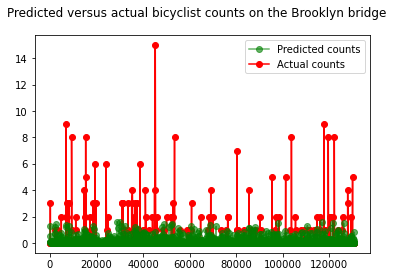

In [13]:
mask = np.random.rand(len(y_test)) < 0.05
predicted_counts = predictions_summary_frame[mask]
actual_counts = y_test[mask]
X_index = X_test[mask]


predicted_counts=predicted_counts['mean']
actual_counts = actual_counts['added']
fig = plt.figure()
fig.suptitle('Predicted versus actual bicyclist counts on the Brooklyn bridge')
actual, = plt.plot(X_index.index, actual_counts, 'ro-', label='Actual counts')
predicted, = plt.plot(X_index.index, predicted_counts, 'go-', alpha = 0.6, label='Predicted counts')

plt.legend(handles=[predicted, actual])
plt.show()

# Goodness of Fit

In [14]:
len(df_train)

91584

### LR test

In [15]:
# The Likelihood-ratio test is used to compare how well two models fit the data.
# The LR test statistic is simply negative two times the difference in the fitted log-likelihoods of the two models.

poisson_ll = -36298
nbr_ll = -23812
-2 * (poisson_ll - nbr_ll)  # NBR is much better

24972

### Chi Squared

In [19]:
df = 91425
# Calculate the p-value
p_value = 1 - chi2.cdf(1.62e+05, df)

# Print the p-value
print("P-value:", p_value)

P-value: 0.0


# Compare Models

In [22]:
def BIC(deviance, k, x):
    # k is the number of parameters, x is the number of observations
    return k * np.log(x) + deviance

def B(BIC1, BIC2):
    # a Bayes factor in the range of 3–10 gives moderate evidence in favour of model 1
    # while a Bayes factor greater than 10 indicates strong evidence in favour of that model 2
    return np.exp(-1/2*(BIC1-BIC2))

In [23]:
# Poisson vs Negative Binomial
BIC_ng = BIC(19611, 7, 91584)
BIC_p = BIC(60717, 7, 91584)
B(BIC_ng, BIC_p)

<ipython-input-22-462e594625bf>:8: RuntimeWarning: overflow encountered in exp
  return np.exp(-1/2*(BIC1-BIC2))


inf

In [37]:
BIC_lr = 2.942e+05
B(BIC_ng, BIC_lr)

<ipython-input-35-462e594625bf>:8: RuntimeWarning: overflow encountered in exp
  return np.exp(-1/2*(BIC1-BIC2))


inf

In [50]:
BIC_ng2 = BIC(21107, 3, 91584)
B(BIC_ng, BIC_ng2)

<ipython-input-35-462e594625bf>:8: RuntimeWarning: overflow encountered in exp
  return np.exp(-1/2*(BIC1-BIC2))


inf

In [25]:
BIC_ng3 = BIC(19512, 5, 91527) # without subscribers_1, rules_and_age
B(BIC_ng, BIC_ng3)

3.466790419901983e-27